### Facial varificaion with a siamese neural network
1. seamese neural network is a oneshot classification.



Network Architecture:


A Siamese neural network consists of two identical subnetworks, a.k.a. twin networks, joined at their outputs. Not only the twin networks have identical architecture, but they also share weights. They work in parallel and are responsible for creating vector representations for the inputs.

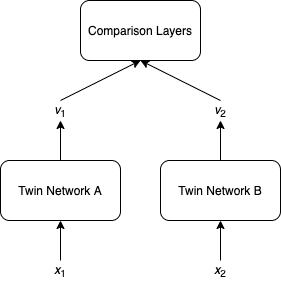

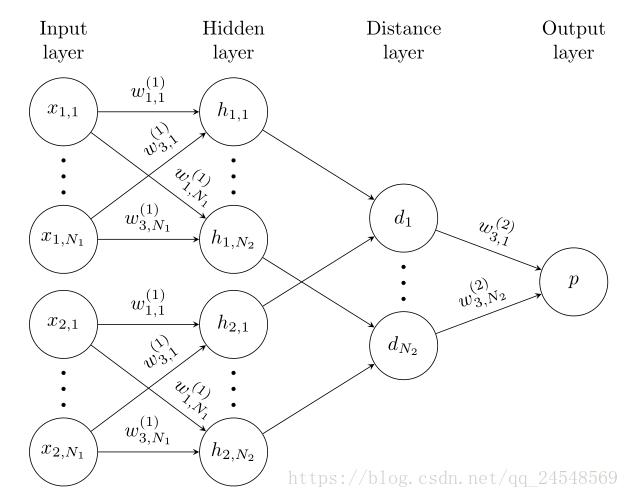 

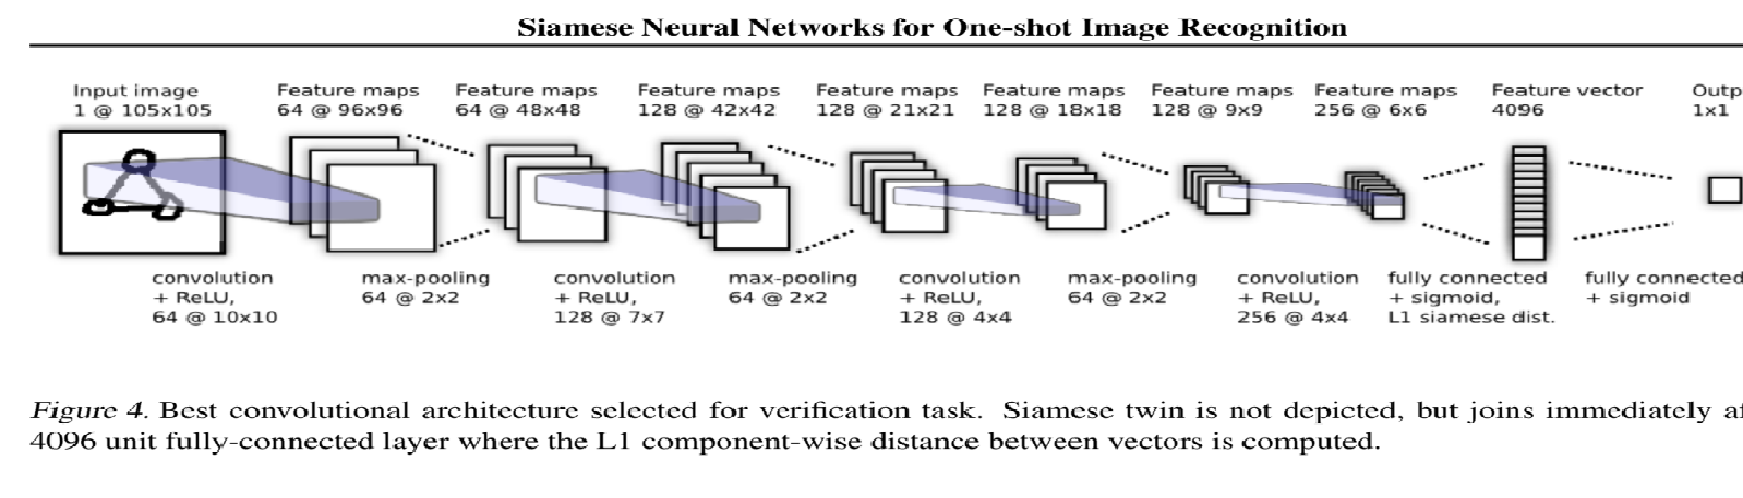

In [1]:
#importing dependencies
import cv2
import os
import random         # might usefull if any data generation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#import tensorflow dependencies-functional apl
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, MaxPooling2D, Input, Flatten,Conv2D
import tensorflow as tf

# setting GPU growth

In [3]:
#This avoids out of memory errors by setting gpu memory consumption growth
Gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in Gpus:
    print(gpu)

# 1. creating some folders for varification.

In [73]:
# setup path for folders
pos_path = os.path.join('data','positive')
neg_path = os.path.join('data','negitive')
anc_path = os.path.join('data','anchor')


#### Here we create one big folder called 'data' inside that we create 3 folders which are ('positive','negitive','anchor')

In [ ]:
#making the directories
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

## 1.1Collecting Positives images and anchors

#### colleccting the labelled Faces in the wild dataset

In [15]:
#http://vis-www.cs.umass.edu/lfw/

In [21]:
#un-compress the Tar GZ labelled Faces which are downloaded from the link which is shown up.
!tar -xf lfw.tgz

In [32]:
#moving all the images from lfw folder to negitive repository data/negitive
for directory in os.listdir('lfw'):               # looping through every directory
    for photos in os.listdir(os.path.join('lfw',directory)): #looping through every photo in directory
        Existing_path = os.path.join('lfw',directory,photos)  # creating the existing path 
        New_path = os.path.join(neg_path,photos)               # creating new path for photos trasfer
        os.replace(Existing_path,New_path)

In [8]:
#importing library called UUID for generating the unique names of photos

import uuid    # (UUID = universally unique identifiers)

In [77]:
# Establising connection to our web cam
cap = cv2.VideoCapture(0)    # '0' argument is for accessing the local machine camera
while cap.isOpened():
    ret, frame = cap.read()   # reading image/ frame one by one, ret returns boolean value
    
    # croppng the frame to 250 x 250
    cr_frame = frame[150:150+250,200:200+250,:]
    
    #Collecting the anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        image_name = os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,cr_frame)
    
    #collecting the positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        image_name = os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,cr_frame)
    
    cv2.imshow('Image',cr_frame)  # display the frame/image
    
    if cv2.waitKey(1) & 0XFF == ord('q'):     # waits untill user press the key
        break
        
cap.release()     # to release the window 
cv2.destroyAllWindows() # to distroy the window if user presses the key    

NameError: name 'uuid' is not defined

## 1.2 Load and Preprocess the images

### 1.3 Get image directories

In [74]:
anchor = tf.data.Dataset.list_files(anc_path + '\*.jpg').take(85)
positive = tf.data.Dataset.list_files(pos_path + '\*.jpg').take(85)
negitive = tf.data.Dataset.list_files(neg_path + '\*.jpg').take(85)

In [75]:
dir_test = anchor.as_numpy_iterator()    #returns the iterator object which converts all elements of the data set to numpy
dir_test

In [76]:
dir_test.next()

b'data\\anchor\\25d83e5e-4f9b-11ed-afd9-30d16bfc42be.jpg'

## 2. Preprocessing-scale and  Resize 

In [14]:
def Preprocessing(file_path):
    bite_image = tf.io.read_file(file_path)  # reading the file using file path
    img = tf.io.decode_jpeg(bite_image)      # Decodes a JPEG image into a 3 dimensional RGB or grayscale tensor.
    img = tf.image.resize(img,(105,105))     # resizing  the image to (105 X 105) dimensions
    img = img / 255.0                        # scaling the image color code to intervel of (0 to 1)
    #scaling helps us gradient descent to work more effiently.
    return img                               # returning the image

In [15]:
img = Preprocessing('data\\anchor\\2538deaf-4f9b-11ed-8642-30d16bfc42be.jpg')

In [16]:
img

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.64705884, 0.5882353 , 0.5764706 ],
        [0.6523009 , 0.5951447 , 0.59235024],
        [0.65368813, 0.5987862 , 0.5966386 ],
        ...,
        [0.89439774, 0.89439774, 0.89439774],
        [0.88506067, 0.88506067, 0.88506067],
        [0.8901961 , 0.8901961 , 0.8901961 ]],

       [[0.6407163 , 0.5945845 , 0.57983196],
        [0.64261705, 0.6       , 0.5846138 ],
        [0.64149   , 0.5967054 , 0.5921569 ],
        ...,
        [0.8880485 , 0.8880485 , 0.8880485 ],
        [0.88573426, 0.88573426, 0.88573426],
        [0.89047617, 0.89047617, 0.89047617]],

       [[0.63558537, 0.60029125, 0.5806834 ],
        [0.63734823, 0.60149395, 0.5827264 ],
        [0.6421658 , 0.5990285 , 0.5911854 ],
        ...,
        [0.8880485 , 0.8880485 , 0.8880485 ],
        [0.8840003 , 0.8840003 , 0.8840003 ],
        [0.89234364, 0.89234364, 0.89234364]],

       ...,

       [[0.2758725 , 0.27979407, 0.360373  ],
        [0.25

## 2.1 Creating labelled dataset


In [17]:
#(anchor,postive)--->[1,1,1,1,1]
#(anchor,negitive)----->[0,0,0,0,0]
tf.ones(len(anchor))

<tf.Tensor: shape=(85,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [18]:
#from_tensor_slices combines in input and returns a dataset with a saparate element of each row of the input tensor.

positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
                                #tf.ones creates all 1 labels if  anchor and positive match
negatives = tf.data.Dataset.zip((anchor,negitive,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
                                ##tf.zeros creates all 0 labels if  anchor and negitives
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator() #returns the iterator object which converts all elements of the data set to numpy

In [20]:
example = samples.next()

In [21]:
example

(b'data\\anchor\\24252025-4f9b-11ed-9f43-30d16bfc42be.jpg',
 b'data\\positive\\034d6f3b-4f9a-11ed-a743-30d16bfc42be.jpg',
 1.0)

# 3. Build Train-test partition

In [22]:
def preprocess_twin(input_img,validation_img,label):
    return (Preprocessing(input_img),Preprocessing(validation_img),label)

In [23]:
res = preprocess_twin(*example) # res contains 2 preprocessed image and 1 label

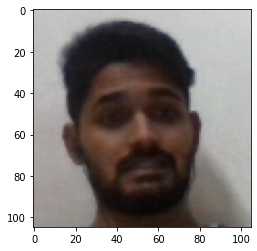

In [24]:
plt.imshow(res[1])

In [25]:
# build the data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:
example_1 = data.as_numpy_iterator()

In [27]:
sam = example_1.next()

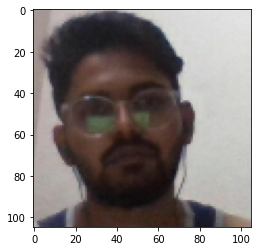

In [28]:
plt.imshow(sam[1])

In [29]:
round(len(data)*.7) #rounding the all data and multiply by 0.7

119

In [30]:
# creating training partitions
train_data = data.take(round(len(data)*.7))# This command will grab the 70% image data into training set.
train_data = train_data.batch(16)  # batching the images in arrays 
train_data = train_data.prefetch(8)

In [31]:
train_sample = train_data.as_numpy_iterator()

In [32]:
train_sample.next()

(array([[[[0.6340803 , 0.59094304, 0.5830999 ],
          [0.6407963 , 0.59681875, 0.5892557 ],
          [0.64435107, 0.5894491 , 0.5819795 ],
          ...,
          [0.8877573 , 0.8877573 , 0.8877573 ],
          [0.88906896, 0.88906896, 0.88906896],
          [0.8920657 , 0.8920657 , 0.8920657 ]],
 
         [[0.64658535, 0.6034481 , 0.59560496],
          [0.6433974 , 0.59947985, 0.5918968 ],
          [0.6469055 , 0.5924637 , 0.5848406 ],
          ...,
          [0.89212346, 0.89212346, 0.89212346],
          [0.88235295, 0.88235295, 0.88235295],
          [0.89375085, 0.89375085, 0.89375085]],
 
         [[0.63800186, 0.5948646 , 0.58702147],
          [0.6430105 , 0.59987324, 0.5920301 ],
          [0.6393846 , 0.5933329 , 0.58451825],
          ...,
          [0.88976705, 0.8933151 , 0.89154106],
          [0.88792187, 0.8914699 , 0.8896959 ],
          [0.8884221 , 0.8919701 , 0.8901961 ]],
 
         ...,
 
         [[0.26637533, 0.27851355, 0.3730047 ],
          [0.24232

In [33]:
#test data partitions
test_data  = data.skip(round(len(data)*.7))  # skipping the 70% train data.
test_data = test_data.take(round(len(data)*.3))   # taking 30% data for testing the model.
test_data = test_data.batch(16)  # batching the images in arrays 
test_data = test_data.prefetch(8)

In [34]:
sample_test = test_data.as_numpy_iterator()

In [35]:
sample_test.next()

(array([[[[0.65723395, 0.602332  , 0.5984104 ],
          [0.65434176, 0.5994398 , 0.59551823],
          [0.6419123 , 0.58591217, 0.5825397 ],
          ...,
          [0.8929038 , 0.88683474, 0.8854342 ],
          [0.8929038 , 0.88506067, 0.88898224],
          [0.8929038 , 0.8929038 , 0.8929038 ]],
 
         [[0.6467787 , 0.6039216 , 0.59607846],
          [0.64257705, 0.5997199 , 0.59187675],
          [0.64058286, 0.59772575, 0.5898826 ],
          ...,
          [0.89611185, 0.8900427 , 0.8886422 ],
          [0.8938376 , 0.88599443, 0.889916  ],
          [0.90746963, 0.8996265 , 0.90354806]],
 
         [[0.6452848 , 0.6060691 , 0.59822595],
          [0.63529414, 0.59607846, 0.5882353 ],
          [0.6331466 , 0.5931284 , 0.58528525],
          ...,
          [0.8999822 , 0.89471567, 0.89331514],
          [0.895765  , 0.88792187, 0.89184344],
          [0.904773  , 0.89692986, 0.9008514 ]],
 
         ...,
 
         [[0.28950906, 0.2702747 , 0.37438303],
          [0.28278

# 4. Model Engineering

#### Deep learning model building and model training starts.

### 4.1 building Embeded layers. 

In [36]:
# creating Embeded layer by writing function.
def embeded_layer():
    inp = Input(shape = (105,105,3), name = 'input_image')
    # first block
    c1 = Conv2D(64,(10,10) ,activation = 'relu')(inp)   # creating Convolutional layer with 10x10 pixes and with ReLU activation function
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)   #  # creating Maxpooling2D layer with 2x2 pixes.
    
    # second block
    c2 = Conv2D(128,(7,7) ,activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    # Third block
    
    c3 = Conv2D(128,(4,4) ,activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    #Final Embeded block
    
    c4 = Conv2D(256, (4,4) , activation = 'relu')(m3)
    f1 = Flatten()(c4)                                  #converting feature into 1D vector.
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
    
    return Model(inputs =[inp], outputs =[d1], name = 'embedding' )

In [37]:
embedding_model = embeded_layer()

In [38]:
embedding_model.summary()    #

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## 4.2 Building  Distance layer

In [39]:
#siamese l1 distance class
class L1Dist(Layer):
    # init  method  - inheritance
    def __init__(self,**kwargs):
        super().__init__()
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [40]:
L1 = L1Dist()

In [41]:
L1

### Making siamese model

In [42]:
# creating siamese model
def siamese_model():
    #anchor image input in the network
    input_image = Input(name = 'input_img' , shape = (105,105,3))
    
    # validation image in the network
    validation_image = Input(name = 'validation_img' , shape = (105,105,3))
    
    #combining siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'Distance'
    distances = siamese_layer(embedding_model(input_image),embedding_model(validation_image))
    
    # Classification Layer
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image], outputs = [classifier], name = 'siameseNetwork')

    

In [43]:
siamese_network = siamese_model()

In [44]:
siamese_network.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

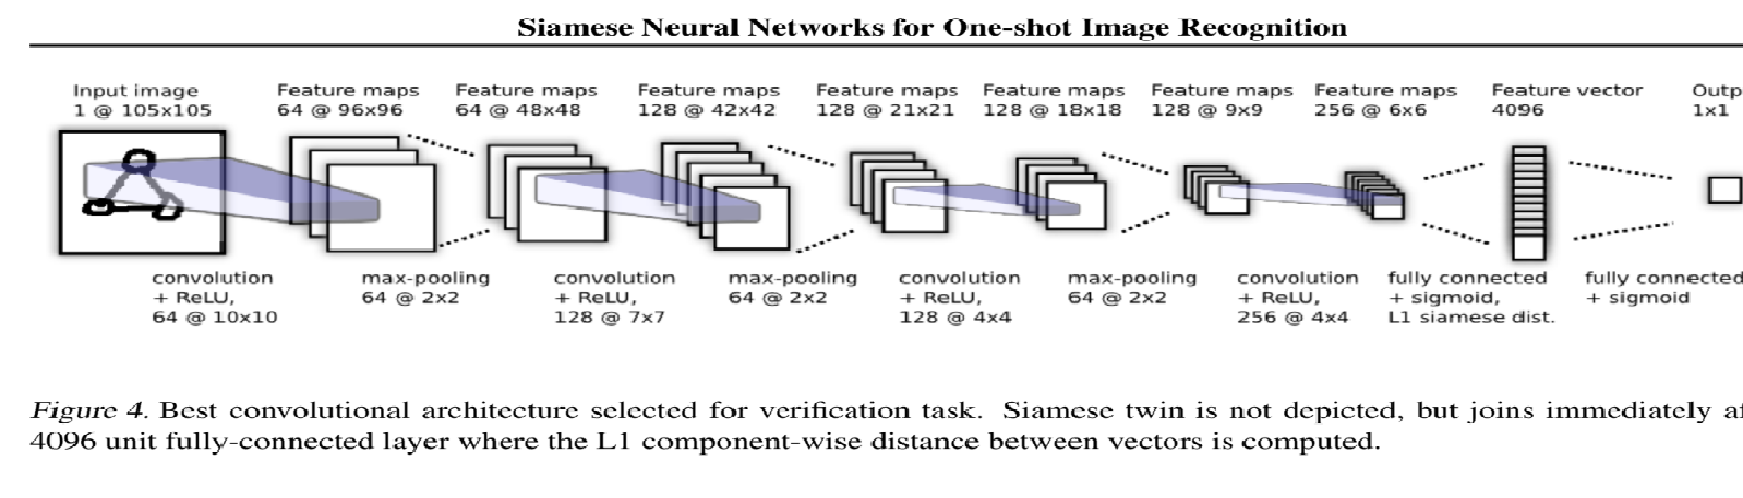

#### Above is the whole siamese neural network.

# 5. Training

### 5.1 setup loss ad optimiser

In [45]:
Binary_cross_loss = tf.losses.BinaryCrossentropy()

In [46]:
opt = tf.keras.optimizers.Adam(1e-4)   # 1e-4 = 0.0001

## 5.2 Establishing check points 

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt,siamese_model = siamese_network)

### 5.3 Build Train step Function

In [42]:
@tf.function
def train_step(batch):
    # For recording all the operations
    with tf.GradientTape() as tape:
        #get anchor image and positive/negitive image
        x = batch[:2]    #it is kind of features
        #get label
        y = batch[2]     # labels for the images
        
        # forword prop
        y_hat = siamese_network(x,training = True)
        # calculating the loss
        loss = Binary_cross_loss(y,y_hat)
        
        #claculating the gradients
        grad = tape.gradient(loss,siamese_network.trainable_variables) #calculates the gradient based on loss and train variables
        
        #calculate updated weights and apply to siamese model
        opt.apply_gradients(zip(grad,siamese_network.trainable_variables))
        
        #return loss
        return loss

### 5.4 Build Training loop

In [43]:
def train(data,EPOCHS):
    #looping through the epochs
    for epoch in range(1,EPOCHS):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # looping through each batch
        for idx,batch in enumerate(data):
            # Run train_step here
            train_step(batch)
            #updating progress bar
            progbar.update(idx+1)
            
        #saving our cheakpoints
        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            

In [68]:
EPOCHS = 50

In [69]:
train(train_data,EPOCHS)

NameError: name 'train' is not defined

In [ ]:
# 6. Evalute the model

In [48]:
# importing the metrics
from tensorflow.keras.metrics import Precision, Recall

### 6.1 Making predictions

In [49]:
# gettign a batch of test data
test_input,test_val,y_true = test_data.as_numpy_iterator().next()

In [50]:
# making redictions
predictions = siamese_network.predict([test_input,test_val])

1/1 [==============================] - 5s 5s/step


In [51]:
predictions

array([[0.5003225 ],
       [0.50089145],
       [0.5005874 ],
       [0.49996153],
       [0.49846703],
       [0.50065154],
       [0.5010842 ],
       [0.50106007],
       [0.5005617 ],
       [0.5003089 ],
       [0.5010374 ],
       [0.5015673 ],
       [0.5003527 ],
       [0.5002444 ],
       [0.50141263],
       [0.5009251 ]], dtype=float32)

In [52]:
#post processing the results
[1 if predict >=0.5 else 0 for predict in predictions]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [53]:
y_true

array([1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

### 6.2 calculating the metrics

In [54]:
r = Recall()
r.update_state(y_true,predictions)
r.result().numpy()

0.875

In [55]:
p = Precision()
p.update_state(y_true,predictions)
r.result().numpy()

0.875

###### Here we got very good precision and recall shows model is very accurate to distinguish the people

### 6.3 visualizing the results

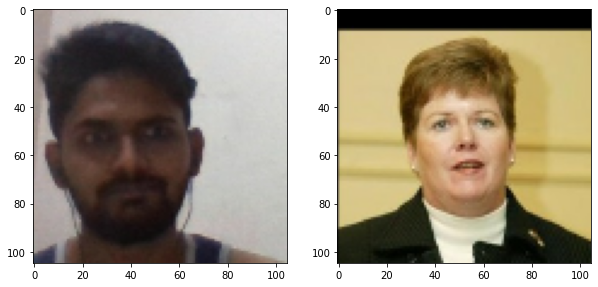

In [56]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(test_input[7])
plt.subplot(1,2,2)
plt.imshow(test_val[7])
plt.show()


# 7. saving the model

In [73]:
# saving the model weights
siamese_network.save('siamese_model.h5')

In [57]:
# tf.keras.models.load_model : this load the model that we have saved using model.save()
model = tf.keras.models.load_model('siamese_model.h5',custom_objects={'L1Dist' :L1Dist,'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [58]:
# viewing our model summery
model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [59]:
# make predictions with reloaded model
model.predict([test_input,test_val])

1/1 [==============================] - 4s 4s/step


array([[1.00000000e+00],
       [7.29799330e-01],
       [1.77602342e-08],
       [1.00000000e+00],
       [2.55202579e-08],
       [9.99450564e-01],
       [2.12963922e-08],
       [1.98714595e-04],
       [4.91557550e-08],
       [9.99552548e-01],
       [9.97235656e-01],
       [1.12570535e-06],
       [9.14817701e-06],
       [9.99999166e-01],
       [1.47300145e-08],
       [9.90798295e-01]], dtype=float32)

# Real time facial recognition testing

### 8.1 varification fucntion

In [64]:
def verify(model,detection_threshold,verification_threshold):
    #building result array
    results = list()
    for image in os.listdir(os.path.join('application_data','varification_images')): # looping through every image in varification_image folder
        input_img = Preprocessing(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = Preprocessing(os.path.join('application_data','varification_images',image))
        
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis = 1)))
        results.append(result)
        
    #detection_threshold : metrics above which our prediction considered as positive
    detection = (np.sum(np.array(results)) > detection_threshold)
    
    #verification_threshold : proportion of positive predictions / total no. of positive samples
    verification = detection / len(os.listdir(os.path.join('application_data','varification_images')))
    verified = verification > verification_threshold
    
    return results, verified
        

### 8.2 open cv real time varification 

In [66]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    cr_frame = frame[150:150+250,200:200+250,:]
    cv2.imshow('verification',cr_frame)
    #verifiction trigger or running varification fucntion above by pressing 'v' on the keyboard.
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #first we have to save image in application_data\input_image
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),cr_frame)
        # Run varification
        results, verified = verify(model,0.5,0.5)
        print(verified)
        
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 471ms/step
False


In [67]:
results

[array([[0.9997602]], dtype=float32),
 array([[0.9999996]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99934787]], dtype=float32),
 array([[0.99726284]], dtype=float32),
 array([[0.99961793]], dtype=float32),
 array([[0.99999595]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999953]], dtype=float32),
 array([[0.9992805]], dtype=float32),
 array([[0.99260104]], dtype=float32),
 array([[0.9962967]], dtype=float32),
 array([[0.997828]], dtype=float32),
 array([[0.9995149]], dtype=float32),
 array([[0.9993422]], dtype=float32),
 array([[0.99955726]], dtype=float32),
 array([[0.9811818]], dtype=